In [1]:
# import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
from backbone1 import DenseNet201b
from dataloader import create_dataloader
from metric import Metric
from ievit3 import IEViT2
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tabulate import tabulate
# from cam_generate import cam_generate
torch.cuda.empty_cache()

# Set device to GPU if available, else use CPU
# device = torch.device("cuda:0")
device = torch.device("cuda")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA RTX A6000


In [2]:
# Define hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 0.000001
in_channel = 3
image_size = 384
# patch_size = 16p
patch_size = [32,32,16,16,16,16,8]
num_workers = 4
embed_dim = 960
mlp_dim = 1024
dim_feedforward = 1024
num_layers = 12
num_labels = 20
thresholds = [0.5] * num_labels
num_classes = 20
data_dir = '../data'

In [3]:
# Create dataloaders (image.shape = torch.Size([batch_size, channel_no, H, W])
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')

384
384


In [4]:
# Define model and optimizer
backbone = DenseNet201b(embed_dim)
# create an instance of IEVIT
model = IEViT2(img_size= image_size, patch_dim = patch_size, in_channels = in_channel, num_classes = num_classes, embed_dim = embed_dim,
               num_heads = num_workers, num_layers = num_layers, dim_feedforward = dim_feedforward, mlp_dim = mlp_dim, backbone=backbone)
model.to(device)

# Wrap your model with DataParallel
# model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])

criterion = nn.BCEWithLogitsLoss()
# Define the optimizer and the learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs= num_epochs, steps_per_epoch=len(train_dataloader))

/home/deependra/project/rfmidc/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/rfmidc/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Initialize Metric class
metric = Metric(num_classes=num_classes)

# create empty lists to store predicted probabilities and true labels for each epoch
val_preds_all, val_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
max_ms = [0,0]

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        loss = criterion(outputs, labels)    
        outputs = torch.sigmoid(outputs)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute metrics on train set
        with torch.no_grad():
            metric.update(outputs, labels, 0)
    
    # Print metrics on train set
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric.compute(1)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")

    # Reset Metric class for evaluation
    metric.reset()
    del images
    del labels
    del outputs
    torch.cuda.empty_cache()

    # Evaluate model on validation set
    model.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            running_loss += criterion(outputs, labels).item()
            outputs = torch.sigmoid(outputs)

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += outputs.tolist()
            val_labels += labels.tolist()
            
            # Compute metrics on validation set
            metric.update(outputs, labels,1)
 
        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric.compute(0)
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(val_dataloader))
        
        if max_ms[0] < model_score: 
            max_ms[0] = model_score
            max_ms[1] = epoch

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        val_preds_all.append(val_preds)
        val_labels_all.append(val_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for validation set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(val_labels_all).ravel(), np.concatenate(val_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))

        print() # empty line for spacing
        
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()   
    
    # Step the learning rate scheduler
    scheduler.step()      

Epoch 1/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [1/200], Loss: 0.3710, ML mAP: 0.0813, ML F1: 0.0467, ML AUC: 0.4998, ML Score: 0.2905, Bin AUC: 0.0526, Model Score: 0.1716, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.91it/s]


Val - Epoch [1/200], Loss: 0.3710, ML mAP: 0.1526, ML F1: 0.0000, ML AUC: 0.7393, ML Score: 0.4459, Bin AUC: 0.4737, Model Score: 0.4598, Bin F1: 0.0000

Epoch 2/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [2/200], Loss: 0.2676, ML mAP: 0.1431, ML F1: 0.0258, ML AUC: 0.6391, ML Score: 0.3911, Bin AUC: 0.6944, Model Score: 0.5428, Bin F1: 0.0000


100%|██████████| 28/28 [00:06<00:00,  4.04it/s]


Val - Epoch [2/200], Loss: 0.2676, ML mAP: 0.2572, ML F1: 0.0000, ML AUC: 0.8216, ML Score: 0.5394, Bin AUC: 0.2105, Model Score: 0.3750, Bin F1: 0.0000

Epoch 3/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [3/200], Loss: 0.2207, ML mAP: 0.2361, ML F1: 0.1114, ML AUC: 0.7568, ML Score: 0.4964, Bin AUC: 0.9216, Model Score: 0.7090, Bin F1: 0.0000


100%|██████████| 28/28 [00:06<00:00,  4.00it/s]


Val - Epoch [3/200], Loss: 0.2207, ML mAP: 0.3468, ML F1: 0.0630, ML AUC: 0.8643, ML Score: 0.6056, Bin AUC: 0.9474, Model Score: 0.7765, Bin F1: 0.0000

Epoch 4/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [4/200], Loss: 0.2559, ML mAP: 0.3014, ML F1: 0.1876, ML AUC: 0.8193, ML Score: 0.5604, Bin AUC: 0.8947, Model Score: 0.7275, Bin F1: 0.0000


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


Val - Epoch [4/200], Loss: 0.2559, ML mAP: 0.4029, ML F1: 0.0485, ML AUC: 0.8633, ML Score: 0.6331, Bin AUC: 0.5263, Model Score: 0.5797, Bin F1: 0.0000

Epoch 5/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [5/200], Loss: 0.1275, ML mAP: 0.4322, ML F1: 0.2832, ML AUC: 0.8658, ML Score: 0.6490, Bin AUC: 0.7368, Model Score: 0.6929, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Val - Epoch [5/200], Loss: 0.1275, ML mAP: 0.4472, ML F1: 0.0686, ML AUC: 0.8812, ML Score: 0.6642, Bin AUC: 0.7368, Model Score: 0.7005, Bin F1: 0.0000

Epoch 6/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [6/200], Loss: 0.1403, ML mAP: 0.5109, ML F1: 0.3709, ML AUC: 0.8924, ML Score: 0.7016, Bin AUC: 0.7500, Model Score: 0.7258, Bin F1: 0.6667


100%|██████████| 28/28 [00:06<00:00,  4.03it/s]


Val - Epoch [6/200], Loss: 0.1403, ML mAP: 0.4750, ML F1: 0.1895, ML AUC: 0.8885, ML Score: 0.6817, Bin AUC: 0.7368, Model Score: 0.7093, Bin F1: 0.0000

Epoch 7/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [7/200], Loss: 0.2625, ML mAP: 0.5661, ML F1: 0.4337, ML AUC: 0.9082, ML Score: 0.7372, Bin AUC: 1.0000, Model Score: 0.8686, Bin F1: 0.6667


100%|██████████| 28/28 [00:06<00:00,  4.03it/s]


Val - Epoch [7/200], Loss: 0.2625, ML mAP: 0.4990, ML F1: 0.1657, ML AUC: 0.8962, ML Score: 0.6976, Bin AUC: 0.7895, Model Score: 0.7435, Bin F1: 0.0000

Epoch 8/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [8/200], Loss: 0.1990, ML mAP: 0.6305, ML F1: 0.4773, ML AUC: 0.9255, ML Score: 0.7780, Bin AUC: 1.0000, Model Score: 0.8890, Bin F1: 0.5000


100%|██████████| 28/28 [00:06<00:00,  4.05it/s]


Val - Epoch [8/200], Loss: 0.1990, ML mAP: 0.4954, ML F1: 0.2112, ML AUC: 0.9020, ML Score: 0.6987, Bin AUC: 0.7368, Model Score: 0.7178, Bin F1: 0.0000

Epoch 9/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [9/200], Loss: 0.1693, ML mAP: 0.6781, ML F1: 0.5223, ML AUC: 0.9393, ML Score: 0.8087, Bin AUC: 1.0000, Model Score: 0.9044, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.93it/s]


Val - Epoch [9/200], Loss: 0.1693, ML mAP: 0.5061, ML F1: 0.2050, ML AUC: 0.9048, ML Score: 0.7055, Bin AUC: 0.6316, Model Score: 0.6685, Bin F1: 0.0000

Epoch 10/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [10/200], Loss: 0.1988, ML mAP: 0.6930, ML F1: 0.5301, ML AUC: 0.9436, ML Score: 0.8183, Bin AUC: 1.0000, Model Score: 0.9091, Bin F1: 0.6667


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


Val - Epoch [10/200], Loss: 0.1988, ML mAP: 0.5147, ML F1: 0.1886, ML AUC: 0.9061, ML Score: 0.7104, Bin AUC: 0.7368, Model Score: 0.7236, Bin F1: 0.0000

Epoch 11/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [11/200], Loss: 0.2036, ML mAP: 0.5861, ML F1: 0.5076, ML AUC: 0.9150, ML Score: 0.7505, Bin AUC: 1.0000, Model Score: 0.8753, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


Val - Epoch [11/200], Loss: 0.2036, ML mAP: 0.5056, ML F1: 0.2597, ML AUC: 0.8960, ML Score: 0.7008, Bin AUC: 0.7895, Model Score: 0.7451, Bin F1: 0.0000

Epoch 12/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [12/200], Loss: 0.2066, ML mAP: 0.6156, ML F1: 0.5344, ML AUC: 0.9203, ML Score: 0.7680, Bin AUC: 1.0000, Model Score: 0.8840, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


Val - Epoch [12/200], Loss: 0.2066, ML mAP: 0.5412, ML F1: 0.3919, ML AUC: 0.9087, ML Score: 0.7250, Bin AUC: 0.7895, Model Score: 0.7572, Bin F1: 0.0000

Epoch 13/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [13/200], Loss: 0.3325, ML mAP: 0.6526, ML F1: 0.5716, ML AUC: 0.9335, ML Score: 0.7931, Bin AUC: 1.0000, Model Score: 0.8965, Bin F1: 0.6667


100%|██████████| 28/28 [00:06<00:00,  4.04it/s]


Val - Epoch [13/200], Loss: 0.3325, ML mAP: 0.5593, ML F1: 0.3902, ML AUC: 0.9109, ML Score: 0.7351, Bin AUC: 0.7368, Model Score: 0.7360, Bin F1: 0.0000

Epoch 14/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [14/200], Loss: 0.2064, ML mAP: 0.6977, ML F1: 0.6254, ML AUC: 0.9459, ML Score: 0.8218, Bin AUC: 0.8421, Model Score: 0.8320, Bin F1: 0.0000


100%|██████████| 28/28 [00:06<00:00,  4.06it/s]


Val - Epoch [14/200], Loss: 0.2064, ML mAP: 0.5994, ML F1: 0.3929, ML AUC: 0.9146, ML Score: 0.7570, Bin AUC: 0.7895, Model Score: 0.7732, Bin F1: 0.0000

Epoch 15/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [15/200], Loss: 0.1796, ML mAP: 0.7417, ML F1: 0.6754, ML AUC: 0.9565, ML Score: 0.8491, Bin AUC: 0.7895, Model Score: 0.8193, Bin F1: 0.0000


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


Val - Epoch [15/200], Loss: 0.1796, ML mAP: 0.5984, ML F1: 0.4492, ML AUC: 0.9170, ML Score: 0.7577, Bin AUC: 0.6316, Model Score: 0.6947, Bin F1: 0.0000

Epoch 16/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [16/200], Loss: 0.0614, ML mAP: 0.7941, ML F1: 0.7243, ML AUC: 0.9623, ML Score: 0.8782, Bin AUC: 0.6842, Model Score: 0.7812, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  4.00it/s]


Val - Epoch [16/200], Loss: 0.0614, ML mAP: 0.5890, ML F1: 0.4270, ML AUC: 0.9177, ML Score: 0.7533, Bin AUC: 0.7368, Model Score: 0.7451, Bin F1: 0.0000

Epoch 17/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [17/200], Loss: 0.2154, ML mAP: 0.8398, ML F1: 0.7715, ML AUC: 0.9723, ML Score: 0.9060, Bin AUC: 0.7895, Model Score: 0.8478, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  4.00it/s]


Val - Epoch [17/200], Loss: 0.2154, ML mAP: 0.6205, ML F1: 0.5024, ML AUC: 0.9216, ML Score: 0.7711, Bin AUC: 0.9474, Model Score: 0.8592, Bin F1: 0.0000

Epoch 18/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [18/200], Loss: 0.1355, ML mAP: 0.8543, ML F1: 0.7910, ML AUC: 0.9764, ML Score: 0.9154, Bin AUC: 1.0000, Model Score: 0.9577, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  4.00it/s]


Val - Epoch [18/200], Loss: 0.1355, ML mAP: 0.6041, ML F1: 0.4856, ML AUC: 0.9240, ML Score: 0.7640, Bin AUC: 0.7895, Model Score: 0.7768, Bin F1: 0.0000

Epoch 19/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [19/200], Loss: 0.0900, ML mAP: 0.8902, ML F1: 0.8294, ML AUC: 0.9824, ML Score: 0.9363, Bin AUC: 1.0000, Model Score: 0.9681, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


Val - Epoch [19/200], Loss: 0.0900, ML mAP: 0.6394, ML F1: 0.4933, ML AUC: 0.9276, ML Score: 0.7835, Bin AUC: 0.6316, Model Score: 0.7076, Bin F1: 0.0000

Epoch 20/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [20/200], Loss: 0.0999, ML mAP: 0.8942, ML F1: 0.8364, ML AUC: 0.9836, ML Score: 0.9389, Bin AUC: 1.0000, Model Score: 0.9695, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Val - Epoch [20/200], Loss: 0.0999, ML mAP: 0.6328, ML F1: 0.5303, ML AUC: 0.9306, ML Score: 0.7817, Bin AUC: 0.6842, Model Score: 0.7329, Bin F1: 0.0000

Epoch 21/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [21/200], Loss: 0.0563, ML mAP: 0.9222, ML F1: 0.8568, ML AUC: 0.9869, ML Score: 0.9546, Bin AUC: 1.0000, Model Score: 0.9773, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Val - Epoch [21/200], Loss: 0.0563, ML mAP: 0.6253, ML F1: 0.4826, ML AUC: 0.9246, ML Score: 0.7750, Bin AUC: 0.9474, Model Score: 0.8612, Bin F1: 0.0000

Epoch 22/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [22/200], Loss: 0.0583, ML mAP: 0.9363, ML F1: 0.8777, ML AUC: 0.9902, ML Score: 0.9633, Bin AUC: 1.0000, Model Score: 0.9816, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Val - Epoch [22/200], Loss: 0.0583, ML mAP: 0.6363, ML F1: 0.5268, ML AUC: 0.9251, ML Score: 0.7807, Bin AUC: 0.7895, Model Score: 0.7851, Bin F1: 0.0000

Epoch 23/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [23/200], Loss: 0.0904, ML mAP: 0.9433, ML F1: 0.8888, ML AUC: 0.9915, ML Score: 0.9674, Bin AUC: 1.0000, Model Score: 0.9837, Bin F1: 0.8000


100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Val - Epoch [23/200], Loss: 0.0904, ML mAP: 0.6322, ML F1: 0.5458, ML AUC: 0.9257, ML Score: 0.7789, Bin AUC: 0.7895, Model Score: 0.7842, Bin F1: 0.0000

Epoch 24/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [24/200], Loss: 0.0521, ML mAP: 0.9512, ML F1: 0.9017, ML AUC: 0.9911, ML Score: 0.9711, Bin AUC: 1.0000, Model Score: 0.9856, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.94it/s]


Val - Epoch [24/200], Loss: 0.0521, ML mAP: 0.6291, ML F1: 0.5487, ML AUC: 0.9249, ML Score: 0.7770, Bin AUC: 0.7895, Model Score: 0.7832, Bin F1: 0.0000

Epoch 25/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [25/200], Loss: 0.0625, ML mAP: 0.9557, ML F1: 0.9090, ML AUC: 0.9929, ML Score: 0.9743, Bin AUC: 1.0000, Model Score: 0.9872, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.95it/s]


Val - Epoch [25/200], Loss: 0.0625, ML mAP: 0.6270, ML F1: 0.5509, ML AUC: 0.9280, ML Score: 0.7775, Bin AUC: 0.9474, Model Score: 0.8624, Bin F1: 0.0000

Epoch 26/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [26/200], Loss: 0.0927, ML mAP: 0.9622, ML F1: 0.9166, ML AUC: 0.9940, ML Score: 0.9781, Bin AUC: 1.0000, Model Score: 0.9890, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Val - Epoch [26/200], Loss: 0.0927, ML mAP: 0.6385, ML F1: 0.5528, ML AUC: 0.9310, ML Score: 0.7847, Bin AUC: 0.8947, Model Score: 0.8397, Bin F1: 0.0000

Epoch 27/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [27/200], Loss: 0.0811, ML mAP: 0.9607, ML F1: 0.9151, ML AUC: 0.9942, ML Score: 0.9775, Bin AUC: 1.0000, Model Score: 0.9887, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.94it/s]


Val - Epoch [27/200], Loss: 0.0811, ML mAP: 0.6410, ML F1: 0.5512, ML AUC: 0.9319, ML Score: 0.7864, Bin AUC: 0.8421, Model Score: 0.8143, Bin F1: 0.0000

Epoch 28/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [28/200], Loss: 0.0915, ML mAP: 0.9685, ML F1: 0.9229, ML AUC: 0.9957, ML Score: 0.9821, Bin AUC: 1.0000, Model Score: 0.9911, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


Val - Epoch [28/200], Loss: 0.0915, ML mAP: 0.6382, ML F1: 0.5577, ML AUC: 0.9308, ML Score: 0.7845, Bin AUC: 0.8947, Model Score: 0.8396, Bin F1: 0.0000

Epoch 29/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [29/200], Loss: 0.0629, ML mAP: 0.9689, ML F1: 0.9278, ML AUC: 0.9961, ML Score: 0.9825, Bin AUC: 1.0000, Model Score: 0.9912, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Val - Epoch [29/200], Loss: 0.0629, ML mAP: 0.6453, ML F1: 0.5444, ML AUC: 0.9295, ML Score: 0.7874, Bin AUC: 0.8947, Model Score: 0.8411, Bin F1: 0.0000

Epoch 30/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [30/200], Loss: 0.0806, ML mAP: 0.9720, ML F1: 0.9326, ML AUC: 0.9963, ML Score: 0.9842, Bin AUC: 1.0000, Model Score: 0.9921, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.02it/s]


Val - Epoch [30/200], Loss: 0.0806, ML mAP: 0.6399, ML F1: 0.5550, ML AUC: 0.9307, ML Score: 0.7853, Bin AUC: 0.8947, Model Score: 0.8400, Bin F1: 0.0000

Epoch 31/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [31/200], Loss: 0.0693, ML mAP: 0.9205, ML F1: 0.8556, ML AUC: 0.9870, ML Score: 0.9538, Bin AUC: 1.0000, Model Score: 0.9769, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.02it/s]


Val - Epoch [31/200], Loss: 0.0693, ML mAP: 0.6432, ML F1: 0.5296, ML AUC: 0.9185, ML Score: 0.7808, Bin AUC: 0.6842, Model Score: 0.7325, Bin F1: 0.0000

Epoch 32/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [32/200], Loss: 0.0614, ML mAP: 0.9113, ML F1: 0.8508, ML AUC: 0.9867, ML Score: 0.9490, Bin AUC: 0.9722, Model Score: 0.9606, Bin F1: 0.6667


100%|██████████| 28/28 [00:06<00:00,  4.04it/s]


Val - Epoch [32/200], Loss: 0.0614, ML mAP: 0.6311, ML F1: 0.5690, ML AUC: 0.9235, ML Score: 0.7773, Bin AUC: 0.8421, Model Score: 0.8097, Bin F1: 0.0000

Epoch 33/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [33/200], Loss: 0.0224, ML mAP: 0.9068, ML F1: 0.8489, ML AUC: 0.9860, ML Score: 0.9464, Bin AUC: 1.0000, Model Score: 0.9732, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.05it/s]


Val - Epoch [33/200], Loss: 0.0224, ML mAP: 0.6239, ML F1: 0.5413, ML AUC: 0.9228, ML Score: 0.7734, Bin AUC: 0.7895, Model Score: 0.7814, Bin F1: 0.0000

Epoch 34/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [34/200], Loss: 0.2776, ML mAP: 0.9364, ML F1: 0.8819, ML AUC: 0.9897, ML Score: 0.9631, Bin AUC: 1.0000, Model Score: 0.9815, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.06it/s]


Val - Epoch [34/200], Loss: 0.2776, ML mAP: 0.6588, ML F1: 0.5862, ML AUC: 0.9326, ML Score: 0.7957, Bin AUC: 0.8421, Model Score: 0.8189, Bin F1: 0.0000

Epoch 35/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [35/200], Loss: 0.0772, ML mAP: 0.9304, ML F1: 0.8730, ML AUC: 0.9899, ML Score: 0.9602, Bin AUC: 1.0000, Model Score: 0.9801, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


Val - Epoch [35/200], Loss: 0.0772, ML mAP: 0.6547, ML F1: 0.5444, ML AUC: 0.9317, ML Score: 0.7932, Bin AUC: 0.8421, Model Score: 0.8177, Bin F1: 0.0000

Epoch 36/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [36/200], Loss: 0.0477, ML mAP: 0.9387, ML F1: 0.8908, ML AUC: 0.9914, ML Score: 0.9651, Bin AUC: 1.0000, Model Score: 0.9825, Bin F1: 0.8000


100%|██████████| 28/28 [00:06<00:00,  4.02it/s]


Val - Epoch [36/200], Loss: 0.0477, ML mAP: 0.6266, ML F1: 0.5767, ML AUC: 0.9249, ML Score: 0.7757, Bin AUC: 0.8421, Model Score: 0.8089, Bin F1: 0.0000

Epoch 37/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [37/200], Loss: 0.1388, ML mAP: 0.9486, ML F1: 0.8953, ML AUC: 0.9929, ML Score: 0.9708, Bin AUC: 1.0000, Model Score: 0.9854, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.00it/s]


Val - Epoch [37/200], Loss: 0.1388, ML mAP: 0.6356, ML F1: 0.5638, ML AUC: 0.9219, ML Score: 0.7788, Bin AUC: 0.8947, Model Score: 0.8368, Bin F1: 0.0000

Epoch 38/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [38/200], Loss: 0.0177, ML mAP: 0.9580, ML F1: 0.9085, ML AUC: 0.9946, ML Score: 0.9763, Bin AUC: 1.0000, Model Score: 0.9881, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.06it/s]


Val - Epoch [38/200], Loss: 0.0177, ML mAP: 0.6271, ML F1: 0.5412, ML AUC: 0.9225, ML Score: 0.7748, Bin AUC: 0.9474, Model Score: 0.8611, Bin F1: 0.0000

Epoch 39/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [39/200], Loss: 0.0942, ML mAP: 0.9577, ML F1: 0.9132, ML AUC: 0.9942, ML Score: 0.9759, Bin AUC: 1.0000, Model Score: 0.9880, Bin F1: 0.6667


100%|██████████| 28/28 [00:06<00:00,  4.04it/s]


Val - Epoch [39/200], Loss: 0.0942, ML mAP: 0.6366, ML F1: 0.5611, ML AUC: 0.9279, ML Score: 0.7823, Bin AUC: 1.0000, Model Score: 0.8911, Bin F1: 0.0000

Epoch 40/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [40/200], Loss: 0.0152, ML mAP: 0.9644, ML F1: 0.9192, ML AUC: 0.9945, ML Score: 0.9794, Bin AUC: 0.9474, Model Score: 0.9634, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  4.00it/s]


Val - Epoch [40/200], Loss: 0.0152, ML mAP: 0.6379, ML F1: 0.5786, ML AUC: 0.9137, ML Score: 0.7758, Bin AUC: 1.0000, Model Score: 0.8879, Bin F1: 0.0000

Epoch 41/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [41/200], Loss: 0.0924, ML mAP: 0.9634, ML F1: 0.9249, ML AUC: 0.9950, ML Score: 0.9792, Bin AUC: 1.0000, Model Score: 0.9896, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


Val - Epoch [41/200], Loss: 0.0924, ML mAP: 0.6349, ML F1: 0.5733, ML AUC: 0.9269, ML Score: 0.7809, Bin AUC: 1.0000, Model Score: 0.8904, Bin F1: 1.0000

Epoch 42/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [42/200], Loss: 0.0076, ML mAP: 0.9764, ML F1: 0.9398, ML AUC: 0.9971, ML Score: 0.9867, Bin AUC: 1.0000, Model Score: 0.9934, Bin F1: 0.6667


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


Val - Epoch [42/200], Loss: 0.0076, ML mAP: 0.6434, ML F1: 0.5591, ML AUC: 0.9320, ML Score: 0.7877, Bin AUC: 0.9474, Model Score: 0.8675, Bin F1: 0.0000

Epoch 43/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [43/200], Loss: 0.0924, ML mAP: 0.9746, ML F1: 0.9382, ML AUC: 0.9966, ML Score: 0.9856, Bin AUC: 1.0000, Model Score: 0.9928, Bin F1: 0.6667


100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Val - Epoch [43/200], Loss: 0.0924, ML mAP: 0.6437, ML F1: 0.5638, ML AUC: 0.9298, ML Score: 0.7868, Bin AUC: 1.0000, Model Score: 0.8934, Bin F1: 0.0000

Epoch 44/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [44/200], Loss: 0.0445, ML mAP: 0.9689, ML F1: 0.9330, ML AUC: 0.9956, ML Score: 0.9823, Bin AUC: 1.0000, Model Score: 0.9911, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Val - Epoch [44/200], Loss: 0.0445, ML mAP: 0.6628, ML F1: 0.5769, ML AUC: 0.9235, ML Score: 0.7932, Bin AUC: 1.0000, Model Score: 0.8966, Bin F1: 0.0000

Epoch 45/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [45/200], Loss: 0.0934, ML mAP: 0.9804, ML F1: 0.9450, ML AUC: 0.9973, ML Score: 0.9889, Bin AUC: 1.0000, Model Score: 0.9944, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.03it/s]


Val - Epoch [45/200], Loss: 0.0934, ML mAP: 0.6652, ML F1: 0.6161, ML AUC: 0.9301, ML Score: 0.7977, Bin AUC: 1.0000, Model Score: 0.8988, Bin F1: 0.0000

Epoch 46/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [46/200], Loss: 0.0165, ML mAP: 0.9831, ML F1: 0.9501, ML AUC: 0.9979, ML Score: 0.9905, Bin AUC: 1.0000, Model Score: 0.9952, Bin F1: 0.6667


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


Val - Epoch [46/200], Loss: 0.0165, ML mAP: 0.6689, ML F1: 0.6075, ML AUC: 0.9259, ML Score: 0.7974, Bin AUC: 1.0000, Model Score: 0.8987, Bin F1: 0.0000

Epoch 47/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [47/200], Loss: 0.0169, ML mAP: 0.9830, ML F1: 0.9557, ML AUC: 0.9981, ML Score: 0.9905, Bin AUC: 1.0000, Model Score: 0.9953, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.02it/s]


Val - Epoch [47/200], Loss: 0.0169, ML mAP: 0.6569, ML F1: 0.5810, ML AUC: 0.9242, ML Score: 0.7905, Bin AUC: 1.0000, Model Score: 0.8953, Bin F1: 1.0000

Epoch 48/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [48/200], Loss: 0.0179, ML mAP: 0.9874, ML F1: 0.9612, ML AUC: 0.9983, ML Score: 0.9929, Bin AUC: 1.0000, Model Score: 0.9964, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


Val - Epoch [48/200], Loss: 0.0179, ML mAP: 0.6592, ML F1: 0.5478, ML AUC: 0.9177, ML Score: 0.7885, Bin AUC: 1.0000, Model Score: 0.8942, Bin F1: 0.0000

Epoch 49/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [49/200], Loss: 0.0229, ML mAP: 0.9885, ML F1: 0.9617, ML AUC: 0.9986, ML Score: 0.9936, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.04it/s]


Val - Epoch [49/200], Loss: 0.0229, ML mAP: 0.6468, ML F1: 0.6005, ML AUC: 0.9240, ML Score: 0.7854, Bin AUC: 0.9474, Model Score: 0.8664, Bin F1: 0.0000

Epoch 50/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [50/200], Loss: 0.0175, ML mAP: 0.9881, ML F1: 0.9620, ML AUC: 0.9985, ML Score: 0.9933, Bin AUC: 1.0000, Model Score: 0.9967, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


Val - Epoch [50/200], Loss: 0.0175, ML mAP: 0.6572, ML F1: 0.6137, ML AUC: 0.9244, ML Score: 0.7908, Bin AUC: 1.0000, Model Score: 0.8954, Bin F1: 0.0000

Epoch 51/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [51/200], Loss: 0.0758, ML mAP: 0.9903, ML F1: 0.9650, ML AUC: 0.9991, ML Score: 0.9947, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.89it/s]


Val - Epoch [51/200], Loss: 0.0758, ML mAP: 0.6661, ML F1: 0.6214, ML AUC: 0.9328, ML Score: 0.7995, Bin AUC: 1.0000, Model Score: 0.8997, Bin F1: 0.0000

Epoch 52/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [52/200], Loss: 0.0521, ML mAP: 0.9859, ML F1: 0.9637, ML AUC: 0.9985, ML Score: 0.9922, Bin AUC: 1.0000, Model Score: 0.9961, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Val - Epoch [52/200], Loss: 0.0521, ML mAP: 0.6824, ML F1: 0.6080, ML AUC: 0.9296, ML Score: 0.8060, Bin AUC: 0.9474, Model Score: 0.8767, Bin F1: 0.0000

Epoch 53/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [53/200], Loss: 0.0645, ML mAP: 0.9917, ML F1: 0.9688, ML AUC: 0.9990, ML Score: 0.9954, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


Val - Epoch [53/200], Loss: 0.0645, ML mAP: 0.6650, ML F1: 0.6113, ML AUC: 0.9309, ML Score: 0.7980, Bin AUC: 1.0000, Model Score: 0.8990, Bin F1: 0.0000

Epoch 54/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [54/200], Loss: 0.0220, ML mAP: 0.9902, ML F1: 0.9696, ML AUC: 0.9992, ML Score: 0.9947, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.94it/s]


Val - Epoch [54/200], Loss: 0.0220, ML mAP: 0.6733, ML F1: 0.6134, ML AUC: 0.9261, ML Score: 0.7997, Bin AUC: 1.0000, Model Score: 0.8999, Bin F1: 0.0000

Epoch 55/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [55/200], Loss: 0.0784, ML mAP: 0.9932, ML F1: 0.9743, ML AUC: 0.9994, ML Score: 0.9963, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.91it/s]


Val - Epoch [55/200], Loss: 0.0784, ML mAP: 0.6638, ML F1: 0.6159, ML AUC: 0.9307, ML Score: 0.7973, Bin AUC: 1.0000, Model Score: 0.8986, Bin F1: 0.0000

Epoch 56/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [56/200], Loss: 0.0096, ML mAP: 0.9947, ML F1: 0.9782, ML AUC: 0.9986, ML Score: 0.9966, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [56/200], Loss: 0.0096, ML mAP: 0.6655, ML F1: 0.6358, ML AUC: 0.9299, ML Score: 0.7977, Bin AUC: 1.0000, Model Score: 0.8988, Bin F1: 0.0000

Epoch 57/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [57/200], Loss: 0.0258, ML mAP: 0.9951, ML F1: 0.9798, ML AUC: 0.9996, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Val - Epoch [57/200], Loss: 0.0258, ML mAP: 0.6659, ML F1: 0.6212, ML AUC: 0.9282, ML Score: 0.7970, Bin AUC: 1.0000, Model Score: 0.8985, Bin F1: 0.0000

Epoch 58/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [58/200], Loss: 0.0629, ML mAP: 0.9963, ML F1: 0.9826, ML AUC: 0.9995, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


Val - Epoch [58/200], Loss: 0.0629, ML mAP: 0.6769, ML F1: 0.6305, ML AUC: 0.9302, ML Score: 0.8035, Bin AUC: 1.0000, Model Score: 0.9018, Bin F1: 0.0000

Epoch 59/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [59/200], Loss: 0.0343, ML mAP: 0.9963, ML F1: 0.9801, ML AUC: 0.9996, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.00it/s]


Val - Epoch [59/200], Loss: 0.0343, ML mAP: 0.6678, ML F1: 0.6187, ML AUC: 0.9331, ML Score: 0.8004, Bin AUC: 1.0000, Model Score: 0.9002, Bin F1: 0.0000

Epoch 60/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [60/200], Loss: 0.0070, ML mAP: 0.9962, ML F1: 0.9801, ML AUC: 0.9996, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.02it/s]


Val - Epoch [60/200], Loss: 0.0070, ML mAP: 0.6588, ML F1: 0.6257, ML AUC: 0.9286, ML Score: 0.7937, Bin AUC: 1.0000, Model Score: 0.8969, Bin F1: 0.0000

Epoch 61/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [61/200], Loss: 0.0172, ML mAP: 0.9959, ML F1: 0.9853, ML AUC: 0.9995, ML Score: 0.9977, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [61/200], Loss: 0.0172, ML mAP: 0.6635, ML F1: 0.6129, ML AUC: 0.9297, ML Score: 0.7966, Bin AUC: 1.0000, Model Score: 0.8983, Bin F1: 0.0000

Epoch 62/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [62/200], Loss: 0.0039, ML mAP: 0.9970, ML F1: 0.9870, ML AUC: 0.9997, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [62/200], Loss: 0.0039, ML mAP: 0.6679, ML F1: 0.6048, ML AUC: 0.9314, ML Score: 0.7996, Bin AUC: 1.0000, Model Score: 0.8998, Bin F1: 0.0000

Epoch 63/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [63/200], Loss: 0.0081, ML mAP: 0.9971, ML F1: 0.9823, ML AUC: 0.9995, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.92it/s]


Val - Epoch [63/200], Loss: 0.0081, ML mAP: 0.6677, ML F1: 0.6042, ML AUC: 0.9309, ML Score: 0.7993, Bin AUC: 1.0000, Model Score: 0.8997, Bin F1: 0.0000

Epoch 64/200
----------


100%|██████████| 111/111 [01:36<00:00,  1.15it/s]


Epoch [64/200], Loss: 0.0250, ML mAP: 0.9962, ML F1: 0.9828, ML AUC: 0.9997, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Val - Epoch [64/200], Loss: 0.0250, ML mAP: 0.6644, ML F1: 0.6050, ML AUC: 0.9292, ML Score: 0.7968, Bin AUC: 1.0000, Model Score: 0.8984, Bin F1: 0.0000

Epoch 65/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [65/200], Loss: 0.0121, ML mAP: 0.9982, ML F1: 0.9899, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 0.6667


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Val - Epoch [65/200], Loss: 0.0121, ML mAP: 0.6716, ML F1: 0.6072, ML AUC: 0.9303, ML Score: 0.8010, Bin AUC: 1.0000, Model Score: 0.9005, Bin F1: 0.0000

Epoch 66/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [66/200], Loss: 0.0046, ML mAP: 0.9979, ML F1: 0.9904, ML AUC: 0.9999, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


Val - Epoch [66/200], Loss: 0.0046, ML mAP: 0.6765, ML F1: 0.6188, ML AUC: 0.9324, ML Score: 0.8045, Bin AUC: 1.0000, Model Score: 0.9022, Bin F1: 0.0000

Epoch 67/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [67/200], Loss: 0.0671, ML mAP: 0.9985, ML F1: 0.9872, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


Val - Epoch [67/200], Loss: 0.0671, ML mAP: 0.6733, ML F1: 0.6116, ML AUC: 0.9302, ML Score: 0.8018, Bin AUC: 1.0000, Model Score: 0.9009, Bin F1: 0.0000

Epoch 68/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [68/200], Loss: 0.0096, ML mAP: 0.9973, ML F1: 0.9846, ML AUC: 0.9998, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


Val - Epoch [68/200], Loss: 0.0096, ML mAP: 0.6716, ML F1: 0.6195, ML AUC: 0.9315, ML Score: 0.8016, Bin AUC: 1.0000, Model Score: 0.9008, Bin F1: 0.0000

Epoch 69/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [69/200], Loss: 0.0640, ML mAP: 0.9975, ML F1: 0.9870, ML AUC: 0.9996, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Val - Epoch [69/200], Loss: 0.0640, ML mAP: 0.6626, ML F1: 0.6132, ML AUC: 0.9308, ML Score: 0.7967, Bin AUC: 1.0000, Model Score: 0.8983, Bin F1: 0.0000

Epoch 70/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [70/200], Loss: 0.2535, ML mAP: 0.9973, ML F1: 0.9873, ML AUC: 0.9996, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Val - Epoch [70/200], Loss: 0.2535, ML mAP: 0.6750, ML F1: 0.6190, ML AUC: 0.9324, ML Score: 0.8037, Bin AUC: 1.0000, Model Score: 0.9019, Bin F1: 0.0000

Epoch 71/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [71/200], Loss: 0.2155, ML mAP: 0.9081, ML F1: 0.8487, ML AUC: 0.9866, ML Score: 0.9473, Bin AUC: 1.0000, Model Score: 0.9737, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.02it/s]


Val - Epoch [71/200], Loss: 0.2155, ML mAP: 0.6114, ML F1: 0.5356, ML AUC: 0.9226, ML Score: 0.7670, Bin AUC: 0.9474, Model Score: 0.8572, Bin F1: 0.0000

Epoch 72/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [72/200], Loss: 0.0096, ML mAP: 0.9326, ML F1: 0.8778, ML AUC: 0.9910, ML Score: 0.9618, Bin AUC: 1.0000, Model Score: 0.9809, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [72/200], Loss: 0.0096, ML mAP: 0.6526, ML F1: 0.5634, ML AUC: 0.9266, ML Score: 0.7896, Bin AUC: 0.7368, Model Score: 0.7632, Bin F1: 0.0000

Epoch 73/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [73/200], Loss: 0.0105, ML mAP: 0.9558, ML F1: 0.9071, ML AUC: 0.9935, ML Score: 0.9746, Bin AUC: 0.9474, Model Score: 0.9610, Bin F1: 0.6667


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Val - Epoch [73/200], Loss: 0.0105, ML mAP: 0.6385, ML F1: 0.5720, ML AUC: 0.9236, ML Score: 0.7811, Bin AUC: 0.8947, Model Score: 0.8379, Bin F1: 0.0000

Epoch 74/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [74/200], Loss: 0.1002, ML mAP: 0.9752, ML F1: 0.9281, ML AUC: 0.9972, ML Score: 0.9862, Bin AUC: 1.0000, Model Score: 0.9931, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.90it/s]


Val - Epoch [74/200], Loss: 0.1002, ML mAP: 0.6382, ML F1: 0.5338, ML AUC: 0.9183, ML Score: 0.7782, Bin AUC: 0.7895, Model Score: 0.7839, Bin F1: 0.0000

Epoch 75/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [75/200], Loss: 0.2088, ML mAP: 0.9649, ML F1: 0.9176, ML AUC: 0.9953, ML Score: 0.9801, Bin AUC: 0.4737, Model Score: 0.7269, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


Val - Epoch [75/200], Loss: 0.2088, ML mAP: 0.6673, ML F1: 0.5959, ML AUC: 0.9183, ML Score: 0.7928, Bin AUC: 0.8421, Model Score: 0.8175, Bin F1: 0.0000

Epoch 76/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [76/200], Loss: 0.0676, ML mAP: 0.9726, ML F1: 0.9295, ML AUC: 0.9965, ML Score: 0.9846, Bin AUC: 1.0000, Model Score: 0.9923, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.02it/s]


Val - Epoch [76/200], Loss: 0.0676, ML mAP: 0.6591, ML F1: 0.5717, ML AUC: 0.9252, ML Score: 0.7922, Bin AUC: 0.8421, Model Score: 0.8171, Bin F1: 0.0000

Epoch 77/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [77/200], Loss: 0.0533, ML mAP: 0.9786, ML F1: 0.9415, ML AUC: 0.9975, ML Score: 0.9880, Bin AUC: 1.0000, Model Score: 0.9940, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.04it/s]


Val - Epoch [77/200], Loss: 0.0533, ML mAP: 0.6332, ML F1: 0.5865, ML AUC: 0.9237, ML Score: 0.7785, Bin AUC: 0.8947, Model Score: 0.8366, Bin F1: 0.0000

Epoch 78/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [78/200], Loss: 0.0296, ML mAP: 0.9799, ML F1: 0.9450, ML AUC: 0.9977, ML Score: 0.9888, Bin AUC: 1.0000, Model Score: 0.9944, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  4.00it/s]


Val - Epoch [78/200], Loss: 0.0296, ML mAP: 0.6455, ML F1: 0.5880, ML AUC: 0.9221, ML Score: 0.7838, Bin AUC: 0.6842, Model Score: 0.7340, Bin F1: 0.0000

Epoch 79/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [79/200], Loss: 0.0604, ML mAP: 0.9847, ML F1: 0.9525, ML AUC: 0.9986, ML Score: 0.9916, Bin AUC: 1.0000, Model Score: 0.9958, Bin F1: 0.6667


100%|██████████| 28/28 [00:07<00:00,  3.95it/s]


Val - Epoch [79/200], Loss: 0.0604, ML mAP: 0.6688, ML F1: 0.6144, ML AUC: 0.9220, ML Score: 0.7954, Bin AUC: 0.7368, Model Score: 0.7661, Bin F1: 0.0000

Epoch 80/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [80/200], Loss: 0.1723, ML mAP: 0.9832, ML F1: 0.9493, ML AUC: 0.9982, ML Score: 0.9907, Bin AUC: 1.0000, Model Score: 0.9953, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.02it/s]


Val - Epoch [80/200], Loss: 0.1723, ML mAP: 0.6356, ML F1: 0.5872, ML AUC: 0.9109, ML Score: 0.7732, Bin AUC: 0.8421, Model Score: 0.8077, Bin F1: 0.0000

Epoch 81/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [81/200], Loss: 0.0153, ML mAP: 0.9776, ML F1: 0.9444, ML AUC: 0.9973, ML Score: 0.9875, Bin AUC: 0.9474, Model Score: 0.9674, Bin F1: 0.0000


100%|██████████| 28/28 [00:06<00:00,  4.05it/s]


Val - Epoch [81/200], Loss: 0.0153, ML mAP: 0.6452, ML F1: 0.5684, ML AUC: 0.9248, ML Score: 0.7850, Bin AUC: 0.8947, Model Score: 0.8399, Bin F1: 0.0000

Epoch 82/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [82/200], Loss: 0.0167, ML mAP: 0.9857, ML F1: 0.9492, ML AUC: 0.9981, ML Score: 0.9919, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.02it/s]


Val - Epoch [82/200], Loss: 0.0167, ML mAP: 0.6650, ML F1: 0.5661, ML AUC: 0.9274, ML Score: 0.7962, Bin AUC: 0.7368, Model Score: 0.7665, Bin F1: 0.0000

Epoch 83/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [83/200], Loss: 0.0126, ML mAP: 0.9838, ML F1: 0.9547, ML AUC: 0.9979, ML Score: 0.9908, Bin AUC: 1.0000, Model Score: 0.9954, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Val - Epoch [83/200], Loss: 0.0126, ML mAP: 0.6267, ML F1: 0.6117, ML AUC: 0.9178, ML Score: 0.7722, Bin AUC: 1.0000, Model Score: 0.8861, Bin F1: 1.0000

Epoch 84/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [84/200], Loss: 0.0151, ML mAP: 0.9831, ML F1: 0.9566, ML AUC: 0.9979, ML Score: 0.9905, Bin AUC: 1.0000, Model Score: 0.9952, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.94it/s]


Val - Epoch [84/200], Loss: 0.0151, ML mAP: 0.6733, ML F1: 0.5943, ML AUC: 0.9214, ML Score: 0.7973, Bin AUC: 1.0000, Model Score: 0.8987, Bin F1: 0.0000

Epoch 85/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [85/200], Loss: 0.0720, ML mAP: 0.9907, ML F1: 0.9654, ML AUC: 0.9991, ML Score: 0.9949, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.02it/s]


Val - Epoch [85/200], Loss: 0.0720, ML mAP: 0.6714, ML F1: 0.6255, ML AUC: 0.9298, ML Score: 0.8006, Bin AUC: 1.0000, Model Score: 0.9003, Bin F1: 0.0000

Epoch 86/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [86/200], Loss: 0.0064, ML mAP: 0.9898, ML F1: 0.9626, ML AUC: 0.9987, ML Score: 0.9942, Bin AUC: 1.0000, Model Score: 0.9971, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.95it/s]


Val - Epoch [86/200], Loss: 0.0064, ML mAP: 0.6563, ML F1: 0.6082, ML AUC: 0.9216, ML Score: 0.7889, Bin AUC: 1.0000, Model Score: 0.8945, Bin F1: 0.0000

Epoch 87/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [87/200], Loss: 0.0924, ML mAP: 0.9875, ML F1: 0.9585, ML AUC: 0.9987, ML Score: 0.9931, Bin AUC: 1.0000, Model Score: 0.9966, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.05it/s]


Val - Epoch [87/200], Loss: 0.0924, ML mAP: 0.6355, ML F1: 0.6153, ML AUC: 0.9177, ML Score: 0.7766, Bin AUC: 0.9474, Model Score: 0.8620, Bin F1: 0.0000

Epoch 88/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [88/200], Loss: 0.0104, ML mAP: 0.9873, ML F1: 0.9574, ML AUC: 0.9980, ML Score: 0.9926, Bin AUC: 1.0000, Model Score: 0.9963, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


Val - Epoch [88/200], Loss: 0.0104, ML mAP: 0.6641, ML F1: 0.6041, ML AUC: 0.9187, ML Score: 0.7914, Bin AUC: 0.9474, Model Score: 0.8694, Bin F1: 0.0000

Epoch 89/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [89/200], Loss: 0.0547, ML mAP: 0.9880, ML F1: 0.9656, ML AUC: 0.9986, ML Score: 0.9933, Bin AUC: 1.0000, Model Score: 0.9967, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Val - Epoch [89/200], Loss: 0.0547, ML mAP: 0.6516, ML F1: 0.6001, ML AUC: 0.9095, ML Score: 0.7806, Bin AUC: 1.0000, Model Score: 0.8903, Bin F1: 0.0000

Epoch 90/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [90/200], Loss: 0.0119, ML mAP: 0.9909, ML F1: 0.9708, ML AUC: 0.9990, ML Score: 0.9949, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.02it/s]


Val - Epoch [90/200], Loss: 0.0119, ML mAP: 0.6334, ML F1: 0.5894, ML AUC: 0.9219, ML Score: 0.7776, Bin AUC: 1.0000, Model Score: 0.8888, Bin F1: 1.0000

Epoch 91/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [91/200], Loss: 0.0099, ML mAP: 0.9929, ML F1: 0.9743, ML AUC: 0.9991, ML Score: 0.9960, Bin AUC: 1.0000, Model Score: 0.9980, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.95it/s]


Val - Epoch [91/200], Loss: 0.0099, ML mAP: 0.6425, ML F1: 0.6171, ML AUC: 0.9153, ML Score: 0.7789, Bin AUC: 1.0000, Model Score: 0.8894, Bin F1: 1.0000

Epoch 92/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [92/200], Loss: 0.1196, ML mAP: 0.9916, ML F1: 0.9732, ML AUC: 0.9992, ML Score: 0.9954, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.02it/s]


Val - Epoch [92/200], Loss: 0.1196, ML mAP: 0.6261, ML F1: 0.5979, ML AUC: 0.9223, ML Score: 0.7742, Bin AUC: 1.0000, Model Score: 0.8871, Bin F1: 1.0000

Epoch 93/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [93/200], Loss: 0.0339, ML mAP: 0.9912, ML F1: 0.9699, ML AUC: 0.9989, ML Score: 0.9950, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.90it/s]


Val - Epoch [93/200], Loss: 0.0339, ML mAP: 0.6534, ML F1: 0.6333, ML AUC: 0.9256, ML Score: 0.7895, Bin AUC: 1.0000, Model Score: 0.8947, Bin F1: 1.0000

Epoch 94/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [94/200], Loss: 0.0669, ML mAP: 0.9929, ML F1: 0.9730, ML AUC: 0.9992, ML Score: 0.9960, Bin AUC: 1.0000, Model Score: 0.9980, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


Val - Epoch [94/200], Loss: 0.0669, ML mAP: 0.6561, ML F1: 0.6309, ML AUC: 0.9248, ML Score: 0.7905, Bin AUC: 1.0000, Model Score: 0.8952, Bin F1: 0.0000

Epoch 95/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [95/200], Loss: 0.0402, ML mAP: 0.9941, ML F1: 0.9747, ML AUC: 0.9995, ML Score: 0.9968, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


Val - Epoch [95/200], Loss: 0.0402, ML mAP: 0.6351, ML F1: 0.6056, ML AUC: 0.9169, ML Score: 0.7760, Bin AUC: 1.0000, Model Score: 0.8880, Bin F1: 0.0000

Epoch 96/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [96/200], Loss: 0.0372, ML mAP: 0.9948, ML F1: 0.9752, ML AUC: 0.9994, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.89it/s]


Val - Epoch [96/200], Loss: 0.0372, ML mAP: 0.6530, ML F1: 0.5960, ML AUC: 0.9235, ML Score: 0.7883, Bin AUC: 1.0000, Model Score: 0.8941, Bin F1: 0.0000

Epoch 97/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [97/200], Loss: 0.0042, ML mAP: 0.9925, ML F1: 0.9687, ML AUC: 0.9992, ML Score: 0.9958, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.93it/s]


Val - Epoch [97/200], Loss: 0.0042, ML mAP: 0.6395, ML F1: 0.5808, ML AUC: 0.9258, ML Score: 0.7827, Bin AUC: 0.8947, Model Score: 0.8387, Bin F1: 0.0000

Epoch 98/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [98/200], Loss: 0.0055, ML mAP: 0.9934, ML F1: 0.9758, ML AUC: 0.9994, ML Score: 0.9964, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


Val - Epoch [98/200], Loss: 0.0055, ML mAP: 0.6540, ML F1: 0.6094, ML AUC: 0.9265, ML Score: 0.7902, Bin AUC: 1.0000, Model Score: 0.8951, Bin F1: 0.0000

Epoch 99/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [99/200], Loss: 0.0027, ML mAP: 0.9943, ML F1: 0.9803, ML AUC: 0.9995, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Val - Epoch [99/200], Loss: 0.0027, ML mAP: 0.6539, ML F1: 0.6173, ML AUC: 0.9337, ML Score: 0.7938, Bin AUC: 1.0000, Model Score: 0.8969, Bin F1: 0.0000

Epoch 100/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [100/200], Loss: 0.1051, ML mAP: 0.9961, ML F1: 0.9799, ML AUC: 0.9995, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Val - Epoch [100/200], Loss: 0.1051, ML mAP: 0.6744, ML F1: 0.6257, ML AUC: 0.9348, ML Score: 0.8046, Bin AUC: 0.8421, Model Score: 0.8234, Bin F1: 0.0000

Epoch 101/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [101/200], Loss: 0.0702, ML mAP: 0.9920, ML F1: 0.9731, ML AUC: 0.9992, ML Score: 0.9956, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Val - Epoch [101/200], Loss: 0.0702, ML mAP: 0.6681, ML F1: 0.6113, ML AUC: 0.9331, ML Score: 0.8006, Bin AUC: 0.9474, Model Score: 0.8740, Bin F1: 0.0000

Epoch 102/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [102/200], Loss: 0.0116, ML mAP: 0.9950, ML F1: 0.9756, ML AUC: 0.9995, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


Val - Epoch [102/200], Loss: 0.0116, ML mAP: 0.6634, ML F1: 0.6091, ML AUC: 0.9317, ML Score: 0.7975, Bin AUC: 1.0000, Model Score: 0.8988, Bin F1: 0.0000

Epoch 103/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [103/200], Loss: 0.0431, ML mAP: 0.9973, ML F1: 0.9814, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 0.6667


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Val - Epoch [103/200], Loss: 0.0431, ML mAP: 0.6671, ML F1: 0.6387, ML AUC: 0.9381, ML Score: 0.8026, Bin AUC: 1.0000, Model Score: 0.9013, Bin F1: 0.0000

Epoch 104/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [104/200], Loss: 0.0140, ML mAP: 0.9948, ML F1: 0.9790, ML AUC: 0.9994, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.93it/s]


Val - Epoch [104/200], Loss: 0.0140, ML mAP: 0.6585, ML F1: 0.6068, ML AUC: 0.9399, ML Score: 0.7992, Bin AUC: 0.9474, Model Score: 0.8733, Bin F1: 0.0000

Epoch 105/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [105/200], Loss: 0.1728, ML mAP: 0.9955, ML F1: 0.9817, ML AUC: 0.9995, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.05it/s]


Val - Epoch [105/200], Loss: 0.1728, ML mAP: 0.6489, ML F1: 0.5997, ML AUC: 0.9315, ML Score: 0.7902, Bin AUC: 1.0000, Model Score: 0.8951, Bin F1: 0.0000

Epoch 106/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [106/200], Loss: 0.0105, ML mAP: 0.9963, ML F1: 0.9803, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Val - Epoch [106/200], Loss: 0.0105, ML mAP: 0.6435, ML F1: 0.5936, ML AUC: 0.9282, ML Score: 0.7858, Bin AUC: 1.0000, Model Score: 0.8929, Bin F1: 0.0000

Epoch 107/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [107/200], Loss: 0.1169, ML mAP: 0.9977, ML F1: 0.9832, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [107/200], Loss: 0.1169, ML mAP: 0.6642, ML F1: 0.6198, ML AUC: 0.9311, ML Score: 0.7976, Bin AUC: 1.0000, Model Score: 0.8988, Bin F1: 0.0000

Epoch 108/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [108/200], Loss: 0.0039, ML mAP: 0.9941, ML F1: 0.9814, ML AUC: 0.9990, ML Score: 0.9966, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.89it/s]


Val - Epoch [108/200], Loss: 0.0039, ML mAP: 0.6735, ML F1: 0.6329, ML AUC: 0.9319, ML Score: 0.8027, Bin AUC: 1.0000, Model Score: 0.9014, Bin F1: 0.0000

Epoch 109/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [109/200], Loss: 0.0976, ML mAP: 0.9979, ML F1: 0.9856, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


Val - Epoch [109/200], Loss: 0.0976, ML mAP: 0.6774, ML F1: 0.6506, ML AUC: 0.9340, ML Score: 0.8057, Bin AUC: 1.0000, Model Score: 0.9029, Bin F1: 0.0000

Epoch 110/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [110/200], Loss: 0.0172, ML mAP: 0.9977, ML F1: 0.9844, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Val - Epoch [110/200], Loss: 0.0172, ML mAP: 0.6664, ML F1: 0.6219, ML AUC: 0.9301, ML Score: 0.7983, Bin AUC: 1.0000, Model Score: 0.8991, Bin F1: 1.0000

Epoch 111/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [111/200], Loss: 0.0040, ML mAP: 0.9991, ML F1: 0.9909, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.89it/s]


Val - Epoch [111/200], Loss: 0.0040, ML mAP: 0.6564, ML F1: 0.6401, ML AUC: 0.9280, ML Score: 0.7922, Bin AUC: 1.0000, Model Score: 0.8961, Bin F1: 1.0000

Epoch 112/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [112/200], Loss: 0.0025, ML mAP: 0.9993, ML F1: 0.9918, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Val - Epoch [112/200], Loss: 0.0025, ML mAP: 0.6673, ML F1: 0.6314, ML AUC: 0.9306, ML Score: 0.7989, Bin AUC: 1.0000, Model Score: 0.8995, Bin F1: 1.0000

Epoch 113/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [113/200], Loss: 0.0005, ML mAP: 0.9985, ML F1: 0.9886, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.03it/s]


Val - Epoch [113/200], Loss: 0.0005, ML mAP: 0.6644, ML F1: 0.6119, ML AUC: 0.9328, ML Score: 0.7986, Bin AUC: 1.0000, Model Score: 0.8993, Bin F1: 0.0000

Epoch 114/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.36it/s]


Epoch [114/200], Loss: 0.0012, ML mAP: 0.9973, ML F1: 0.9872, ML AUC: 0.9995, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.04it/s]


Val - Epoch [114/200], Loss: 0.0012, ML mAP: 0.6661, ML F1: 0.6297, ML AUC: 0.9340, ML Score: 0.8000, Bin AUC: 1.0000, Model Score: 0.9000, Bin F1: 0.0000

Epoch 115/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [115/200], Loss: 0.0069, ML mAP: 0.9977, ML F1: 0.9883, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.94it/s]


Val - Epoch [115/200], Loss: 0.0069, ML mAP: 0.6724, ML F1: 0.6259, ML AUC: 0.9361, ML Score: 0.8043, Bin AUC: 0.9474, Model Score: 0.8758, Bin F1: 0.0000

Epoch 116/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [116/200], Loss: 0.0007, ML mAP: 0.9989, ML F1: 0.9908, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.94it/s]


Val - Epoch [116/200], Loss: 0.0007, ML mAP: 0.6777, ML F1: 0.6470, ML AUC: 0.9341, ML Score: 0.8059, Bin AUC: 1.0000, Model Score: 0.9029, Bin F1: 0.0000

Epoch 117/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [117/200], Loss: 0.0018, ML mAP: 0.9983, ML F1: 0.9891, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.92it/s]


Val - Epoch [117/200], Loss: 0.0018, ML mAP: 0.6777, ML F1: 0.6434, ML AUC: 0.9298, ML Score: 0.8037, Bin AUC: 1.0000, Model Score: 0.9019, Bin F1: 0.0000

Epoch 118/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [118/200], Loss: 0.0788, ML mAP: 0.9993, ML F1: 0.9907, ML AUC: 1.0000, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.95it/s]


Val - Epoch [118/200], Loss: 0.0788, ML mAP: 0.6663, ML F1: 0.6418, ML AUC: 0.9295, ML Score: 0.7979, Bin AUC: 1.0000, Model Score: 0.8989, Bin F1: 0.0000

Epoch 119/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [119/200], Loss: 0.0174, ML mAP: 0.9987, ML F1: 0.9894, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.03it/s]


Val - Epoch [119/200], Loss: 0.0174, ML mAP: 0.6715, ML F1: 0.6356, ML AUC: 0.9324, ML Score: 0.8020, Bin AUC: 1.0000, Model Score: 0.9010, Bin F1: 0.0000

Epoch 120/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [120/200], Loss: 0.0049, ML mAP: 0.9986, ML F1: 0.9905, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Val - Epoch [120/200], Loss: 0.0049, ML mAP: 0.6721, ML F1: 0.6321, ML AUC: 0.9299, ML Score: 0.8010, Bin AUC: 1.0000, Model Score: 0.9005, Bin F1: 0.0000

Epoch 121/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [121/200], Loss: 0.0008, ML mAP: 0.9986, ML F1: 0.9917, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


Val - Epoch [121/200], Loss: 0.0008, ML mAP: 0.6753, ML F1: 0.6300, ML AUC: 0.9343, ML Score: 0.8048, Bin AUC: 1.0000, Model Score: 0.9024, Bin F1: 0.0000

Epoch 122/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [122/200], Loss: 0.0002, ML mAP: 0.9994, ML F1: 0.9954, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.90it/s]


Val - Epoch [122/200], Loss: 0.0002, ML mAP: 0.6831, ML F1: 0.6480, ML AUC: 0.9325, ML Score: 0.8078, Bin AUC: 1.0000, Model Score: 0.9039, Bin F1: 0.0000

Epoch 123/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [123/200], Loss: 0.0058, ML mAP: 0.9983, ML F1: 0.9914, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Val - Epoch [123/200], Loss: 0.0058, ML mAP: 0.6782, ML F1: 0.6466, ML AUC: 0.9287, ML Score: 0.8035, Bin AUC: 1.0000, Model Score: 0.9017, Bin F1: 0.0000

Epoch 124/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [124/200], Loss: 0.0014, ML mAP: 0.9988, ML F1: 0.9953, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


Val - Epoch [124/200], Loss: 0.0014, ML mAP: 0.6682, ML F1: 0.6253, ML AUC: 0.9299, ML Score: 0.7991, Bin AUC: 1.0000, Model Score: 0.8995, Bin F1: 0.0000

Epoch 125/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [125/200], Loss: 0.0044, ML mAP: 0.9995, ML F1: 0.9936, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


Val - Epoch [125/200], Loss: 0.0044, ML mAP: 0.6736, ML F1: 0.6499, ML AUC: 0.9325, ML Score: 0.8030, Bin AUC: 1.0000, Model Score: 0.9015, Bin F1: 1.0000

Epoch 126/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [126/200], Loss: 0.0010, ML mAP: 0.9996, ML F1: 0.9935, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Val - Epoch [126/200], Loss: 0.0010, ML mAP: 0.6721, ML F1: 0.6320, ML AUC: 0.9342, ML Score: 0.8032, Bin AUC: 1.0000, Model Score: 0.9016, Bin F1: 0.0000

Epoch 127/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [127/200], Loss: 0.0028, ML mAP: 0.9993, ML F1: 0.9943, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.95it/s]


Val - Epoch [127/200], Loss: 0.0028, ML mAP: 0.6785, ML F1: 0.6533, ML AUC: 0.9332, ML Score: 0.8059, Bin AUC: 1.0000, Model Score: 0.9029, Bin F1: 0.0000

Epoch 128/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [128/200], Loss: 0.0835, ML mAP: 0.9997, ML F1: 0.9955, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.03it/s]


Val - Epoch [128/200], Loss: 0.0835, ML mAP: 0.6778, ML F1: 0.6484, ML AUC: 0.9336, ML Score: 0.8057, Bin AUC: 1.0000, Model Score: 0.9028, Bin F1: 0.0000

Epoch 129/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [129/200], Loss: 0.0007, ML mAP: 0.9995, ML F1: 0.9943, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Val - Epoch [129/200], Loss: 0.0007, ML mAP: 0.6754, ML F1: 0.6505, ML AUC: 0.9322, ML Score: 0.8038, Bin AUC: 1.0000, Model Score: 0.9019, Bin F1: 0.0000

Epoch 130/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [130/200], Loss: 0.0004, ML mAP: 0.9996, ML F1: 0.9954, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.93it/s]


Val - Epoch [130/200], Loss: 0.0004, ML mAP: 0.6684, ML F1: 0.6521, ML AUC: 0.9326, ML Score: 0.8005, Bin AUC: 1.0000, Model Score: 0.9002, Bin F1: 0.0000

Epoch 131/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [131/200], Loss: 0.0013, ML mAP: 0.9998, ML F1: 0.9948, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.04it/s]


Val - Epoch [131/200], Loss: 0.0013, ML mAP: 0.6760, ML F1: 0.6617, ML AUC: 0.9319, ML Score: 0.8040, Bin AUC: 1.0000, Model Score: 0.9020, Bin F1: 0.0000

Epoch 132/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [132/200], Loss: 0.0029, ML mAP: 0.9981, ML F1: 0.9935, ML AUC: 0.9995, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.03it/s]


Val - Epoch [132/200], Loss: 0.0029, ML mAP: 0.6770, ML F1: 0.6468, ML AUC: 0.9357, ML Score: 0.8063, Bin AUC: 1.0000, Model Score: 0.9032, Bin F1: 0.0000

Epoch 133/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [133/200], Loss: 0.0016, ML mAP: 0.9993, ML F1: 0.9946, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.00it/s]


Val - Epoch [133/200], Loss: 0.0016, ML mAP: 0.6715, ML F1: 0.6411, ML AUC: 0.9338, ML Score: 0.8027, Bin AUC: 1.0000, Model Score: 0.9013, Bin F1: 0.0000

Epoch 134/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [134/200], Loss: 0.0303, ML mAP: 0.9998, ML F1: 0.9951, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Val - Epoch [134/200], Loss: 0.0303, ML mAP: 0.6687, ML F1: 0.6549, ML AUC: 0.9338, ML Score: 0.8012, Bin AUC: 1.0000, Model Score: 0.9006, Bin F1: 0.0000

Epoch 135/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [135/200], Loss: 0.0164, ML mAP: 0.9996, ML F1: 0.9956, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


Val - Epoch [135/200], Loss: 0.0164, ML mAP: 0.6741, ML F1: 0.6434, ML AUC: 0.9336, ML Score: 0.8039, Bin AUC: 1.0000, Model Score: 0.9019, Bin F1: 0.0000

Epoch 136/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [136/200], Loss: 0.0079, ML mAP: 0.9996, ML F1: 0.9966, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  4.00it/s]


Val - Epoch [136/200], Loss: 0.0079, ML mAP: 0.6745, ML F1: 0.6595, ML AUC: 0.9326, ML Score: 0.8036, Bin AUC: 1.0000, Model Score: 0.9018, Bin F1: 0.0000

Epoch 137/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [137/200], Loss: 0.0008, ML mAP: 0.9998, ML F1: 0.9961, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


Val - Epoch [137/200], Loss: 0.0008, ML mAP: 0.6668, ML F1: 0.6528, ML AUC: 0.9322, ML Score: 0.7995, Bin AUC: 1.0000, Model Score: 0.8998, Bin F1: 0.0000

Epoch 138/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [138/200], Loss: 0.0008, ML mAP: 0.9994, ML F1: 0.9960, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  4.00it/s]


Val - Epoch [138/200], Loss: 0.0008, ML mAP: 0.6687, ML F1: 0.6442, ML AUC: 0.9322, ML Score: 0.8005, Bin AUC: 1.0000, Model Score: 0.9002, Bin F1: 0.0000

Epoch 139/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [139/200], Loss: 0.1101, ML mAP: 0.9995, ML F1: 0.9967, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.00it/s]


Val - Epoch [139/200], Loss: 0.1101, ML mAP: 0.6696, ML F1: 0.6548, ML AUC: 0.9314, ML Score: 0.8005, Bin AUC: 1.0000, Model Score: 0.9003, Bin F1: 0.0000

Epoch 140/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [140/200], Loss: 0.0192, ML mAP: 0.9995, ML F1: 0.9964, ML AUC: 0.9998, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  4.00it/s]


Val - Epoch [140/200], Loss: 0.0192, ML mAP: 0.6705, ML F1: 0.6574, ML AUC: 0.9318, ML Score: 0.8012, Bin AUC: 1.0000, Model Score: 0.9006, Bin F1: 0.0000

Epoch 141/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [141/200], Loss: 0.0065, ML mAP: 0.9997, ML F1: 0.9957, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.04it/s]


Val - Epoch [141/200], Loss: 0.0065, ML mAP: 0.6702, ML F1: 0.6690, ML AUC: 0.9323, ML Score: 0.8013, Bin AUC: 1.0000, Model Score: 0.9006, Bin F1: 0.0000

Epoch 142/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [142/200], Loss: 0.0005, ML mAP: 0.9995, ML F1: 0.9957, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


Val - Epoch [142/200], Loss: 0.0005, ML mAP: 0.6722, ML F1: 0.6726, ML AUC: 0.9323, ML Score: 0.8023, Bin AUC: 1.0000, Model Score: 0.9011, Bin F1: 0.0000

Epoch 143/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [143/200], Loss: 0.0117, ML mAP: 0.9999, ML F1: 0.9966, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


Val - Epoch [143/200], Loss: 0.0117, ML mAP: 0.6714, ML F1: 0.6449, ML AUC: 0.9314, ML Score: 0.8014, Bin AUC: 1.0000, Model Score: 0.9007, Bin F1: 0.0000

Epoch 144/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [144/200], Loss: 0.0004, ML mAP: 0.9998, ML F1: 0.9955, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.93it/s]


Val - Epoch [144/200], Loss: 0.0004, ML mAP: 0.6721, ML F1: 0.6710, ML AUC: 0.9331, ML Score: 0.8026, Bin AUC: 1.0000, Model Score: 0.9013, Bin F1: 0.0000

Epoch 145/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [145/200], Loss: 0.0001, ML mAP: 0.9996, ML F1: 0.9961, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


Val - Epoch [145/200], Loss: 0.0001, ML mAP: 0.6717, ML F1: 0.6641, ML AUC: 0.9333, ML Score: 0.8025, Bin AUC: 1.0000, Model Score: 0.9013, Bin F1: 0.0000

Epoch 146/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [146/200], Loss: 0.0006, ML mAP: 0.9998, ML F1: 0.9969, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.03it/s]


Val - Epoch [146/200], Loss: 0.0006, ML mAP: 0.6743, ML F1: 0.6680, ML AUC: 0.9324, ML Score: 0.8034, Bin AUC: 1.0000, Model Score: 0.9017, Bin F1: 0.0000

Epoch 147/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [147/200], Loss: 0.0618, ML mAP: 0.9996, ML F1: 0.9961, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.02it/s]


Val - Epoch [147/200], Loss: 0.0618, ML mAP: 0.6716, ML F1: 0.6604, ML AUC: 0.9315, ML Score: 0.8016, Bin AUC: 1.0000, Model Score: 0.9008, Bin F1: 0.0000

Epoch 148/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [148/200], Loss: 0.0023, ML mAP: 0.9996, ML F1: 0.9959, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  4.00it/s]


Val - Epoch [148/200], Loss: 0.0023, ML mAP: 0.6724, ML F1: 0.6593, ML AUC: 0.9330, ML Score: 0.8027, Bin AUC: 1.0000, Model Score: 0.9014, Bin F1: 0.0000

Epoch 149/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [149/200], Loss: 0.0100, ML mAP: 1.0000, ML F1: 0.9980, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.02it/s]


Val - Epoch [149/200], Loss: 0.0100, ML mAP: 0.6728, ML F1: 0.6643, ML AUC: 0.9337, ML Score: 0.8032, Bin AUC: 1.0000, Model Score: 0.9016, Bin F1: 0.0000

Epoch 150/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [150/200], Loss: 0.0002, ML mAP: 0.9993, ML F1: 0.9955, ML AUC: 0.9998, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.02it/s]


Val - Epoch [150/200], Loss: 0.0002, ML mAP: 0.6743, ML F1: 0.6563, ML AUC: 0.9337, ML Score: 0.8040, Bin AUC: 1.0000, Model Score: 0.9020, Bin F1: 0.0000

Epoch 151/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [151/200], Loss: 0.3758, ML mAP: 0.9537, ML F1: 0.8992, ML AUC: 0.9932, ML Score: 0.9734, Bin AUC: 1.0000, Model Score: 0.9867, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Val - Epoch [151/200], Loss: 0.3758, ML mAP: 0.5983, ML F1: 0.5795, ML AUC: 0.9049, ML Score: 0.7516, Bin AUC: 1.0000, Model Score: 0.8758, Bin F1: 0.0000

Epoch 152/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [152/200], Loss: 0.0292, ML mAP: 0.9357, ML F1: 0.8767, ML AUC: 0.9914, ML Score: 0.9635, Bin AUC: 1.0000, Model Score: 0.9818, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.94it/s]


Val - Epoch [152/200], Loss: 0.0292, ML mAP: 0.6343, ML F1: 0.5777, ML AUC: 0.9247, ML Score: 0.7795, Bin AUC: 0.9474, Model Score: 0.8634, Bin F1: 0.0000

Epoch 153/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [153/200], Loss: 0.2433, ML mAP: 0.9810, ML F1: 0.9421, ML AUC: 0.9974, ML Score: 0.9892, Bin AUC: 1.0000, Model Score: 0.9946, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  4.00it/s]


Val - Epoch [153/200], Loss: 0.2433, ML mAP: 0.6368, ML F1: 0.6075, ML AUC: 0.9194, ML Score: 0.7781, Bin AUC: 1.0000, Model Score: 0.8891, Bin F1: 0.0000

Epoch 154/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [154/200], Loss: 0.0447, ML mAP: 0.9858, ML F1: 0.9556, ML AUC: 0.9983, ML Score: 0.9921, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.95it/s]


Val - Epoch [154/200], Loss: 0.0447, ML mAP: 0.6854, ML F1: 0.6373, ML AUC: 0.9288, ML Score: 0.8071, Bin AUC: 0.8947, Model Score: 0.8509, Bin F1: 0.0000

Epoch 155/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [155/200], Loss: 0.0991, ML mAP: 0.9885, ML F1: 0.9577, ML AUC: 0.9988, ML Score: 0.9936, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


Val - Epoch [155/200], Loss: 0.0991, ML mAP: 0.6572, ML F1: 0.6143, ML AUC: 0.9240, ML Score: 0.7906, Bin AUC: 1.0000, Model Score: 0.8953, Bin F1: 1.0000

Epoch 156/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [156/200], Loss: 0.0274, ML mAP: 0.9911, ML F1: 0.9648, ML AUC: 0.9990, ML Score: 0.9951, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


Val - Epoch [156/200], Loss: 0.0274, ML mAP: 0.6762, ML F1: 0.6230, ML AUC: 0.9348, ML Score: 0.8055, Bin AUC: 0.9474, Model Score: 0.8764, Bin F1: 0.0000

Epoch 157/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [157/200], Loss: 0.0055, ML mAP: 0.9932, ML F1: 0.9679, ML AUC: 0.9993, ML Score: 0.9963, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.95it/s]


Val - Epoch [157/200], Loss: 0.0055, ML mAP: 0.6790, ML F1: 0.6115, ML AUC: 0.9316, ML Score: 0.8053, Bin AUC: 0.8947, Model Score: 0.8500, Bin F1: 0.0000

Epoch 158/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [158/200], Loss: 0.0231, ML mAP: 0.9912, ML F1: 0.9654, ML AUC: 0.9987, ML Score: 0.9950, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.03it/s]


Val - Epoch [158/200], Loss: 0.0231, ML mAP: 0.6646, ML F1: 0.6522, ML AUC: 0.9304, ML Score: 0.7975, Bin AUC: 1.0000, Model Score: 0.8988, Bin F1: 1.0000

Epoch 159/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [159/200], Loss: 0.0436, ML mAP: 0.9933, ML F1: 0.9732, ML AUC: 0.9993, ML Score: 0.9963, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.00it/s]


Val - Epoch [159/200], Loss: 0.0436, ML mAP: 0.6473, ML F1: 0.6178, ML AUC: 0.9204, ML Score: 0.7839, Bin AUC: 0.9474, Model Score: 0.8656, Bin F1: 0.0000

Epoch 160/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [160/200], Loss: 0.0058, ML mAP: 0.9891, ML F1: 0.9570, ML AUC: 0.9986, ML Score: 0.9938, Bin AUC: 1.0000, Model Score: 0.9969, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  4.00it/s]


Val - Epoch [160/200], Loss: 0.0058, ML mAP: 0.6419, ML F1: 0.6141, ML AUC: 0.9228, ML Score: 0.7823, Bin AUC: 1.0000, Model Score: 0.8912, Bin F1: 0.0000

Epoch 161/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [161/200], Loss: 0.0149, ML mAP: 0.9913, ML F1: 0.9667, ML AUC: 0.9989, ML Score: 0.9951, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


Val - Epoch [161/200], Loss: 0.0149, ML mAP: 0.6470, ML F1: 0.6207, ML AUC: 0.9195, ML Score: 0.7832, Bin AUC: 1.0000, Model Score: 0.8916, Bin F1: 0.0000

Epoch 162/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [162/200], Loss: 0.0021, ML mAP: 0.9931, ML F1: 0.9695, ML AUC: 0.9990, ML Score: 0.9960, Bin AUC: 1.0000, Model Score: 0.9980, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Val - Epoch [162/200], Loss: 0.0021, ML mAP: 0.6495, ML F1: 0.6243, ML AUC: 0.9253, ML Score: 0.7874, Bin AUC: 0.9474, Model Score: 0.8674, Bin F1: 0.0000

Epoch 163/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [163/200], Loss: 0.0923, ML mAP: 0.9948, ML F1: 0.9746, ML AUC: 0.9990, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Val - Epoch [163/200], Loss: 0.0923, ML mAP: 0.6737, ML F1: 0.6104, ML AUC: 0.9314, ML Score: 0.8026, Bin AUC: 0.8421, Model Score: 0.8223, Bin F1: 0.0000

Epoch 164/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [164/200], Loss: 0.0056, ML mAP: 0.9937, ML F1: 0.9745, ML AUC: 0.9994, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Val - Epoch [164/200], Loss: 0.0056, ML mAP: 0.6619, ML F1: 0.6139, ML AUC: 0.9300, ML Score: 0.7959, Bin AUC: 1.0000, Model Score: 0.8980, Bin F1: 1.0000

Epoch 165/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [165/200], Loss: 0.0491, ML mAP: 0.9937, ML F1: 0.9773, ML AUC: 0.9990, ML Score: 0.9963, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


Val - Epoch [165/200], Loss: 0.0491, ML mAP: 0.6657, ML F1: 0.6330, ML AUC: 0.9310, ML Score: 0.7984, Bin AUC: 1.0000, Model Score: 0.8992, Bin F1: 0.0000

Epoch 166/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [166/200], Loss: 0.0023, ML mAP: 0.9940, ML F1: 0.9718, ML AUC: 0.9992, ML Score: 0.9966, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Val - Epoch [166/200], Loss: 0.0023, ML mAP: 0.6571, ML F1: 0.6253, ML AUC: 0.9281, ML Score: 0.7926, Bin AUC: 1.0000, Model Score: 0.8963, Bin F1: 0.0000

Epoch 167/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [167/200], Loss: 0.1468, ML mAP: 0.9952, ML F1: 0.9762, ML AUC: 0.9994, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.92it/s]


Val - Epoch [167/200], Loss: 0.1468, ML mAP: 0.6689, ML F1: 0.6098, ML AUC: 0.9307, ML Score: 0.7998, Bin AUC: 1.0000, Model Score: 0.8999, Bin F1: 0.0000

Epoch 168/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [168/200], Loss: 0.0212, ML mAP: 0.9919, ML F1: 0.9684, ML AUC: 0.9989, ML Score: 0.9954, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Val - Epoch [168/200], Loss: 0.0212, ML mAP: 0.6582, ML F1: 0.6156, ML AUC: 0.9294, ML Score: 0.7938, Bin AUC: 0.8421, Model Score: 0.8180, Bin F1: 0.0000

Epoch 169/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [169/200], Loss: 0.0674, ML mAP: 0.9933, ML F1: 0.9720, ML AUC: 0.9992, ML Score: 0.9962, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Val - Epoch [169/200], Loss: 0.0674, ML mAP: 0.6671, ML F1: 0.6296, ML AUC: 0.9301, ML Score: 0.7986, Bin AUC: 0.9474, Model Score: 0.8730, Bin F1: 0.0000

Epoch 170/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [170/200], Loss: 0.0944, ML mAP: 0.9928, ML F1: 0.9718, ML AUC: 0.9994, ML Score: 0.9961, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.89it/s]


Val - Epoch [170/200], Loss: 0.0944, ML mAP: 0.6722, ML F1: 0.6158, ML AUC: 0.9338, ML Score: 0.8030, Bin AUC: 0.7895, Model Score: 0.7962, Bin F1: 0.0000

Epoch 171/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [171/200], Loss: 0.0107, ML mAP: 0.9969, ML F1: 0.9794, ML AUC: 0.9995, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 0.8000


100%|██████████| 28/28 [00:07<00:00,  3.92it/s]


Val - Epoch [171/200], Loss: 0.0107, ML mAP: 0.6723, ML F1: 0.6323, ML AUC: 0.9286, ML Score: 0.8004, Bin AUC: 1.0000, Model Score: 0.9002, Bin F1: 0.0000

Epoch 172/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [172/200], Loss: 0.0654, ML mAP: 0.9961, ML F1: 0.9785, ML AUC: 0.9995, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


Val - Epoch [172/200], Loss: 0.0654, ML mAP: 0.6755, ML F1: 0.6180, ML AUC: 0.9319, ML Score: 0.8037, Bin AUC: 1.0000, Model Score: 0.9018, Bin F1: 1.0000

Epoch 173/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [173/200], Loss: 0.0075, ML mAP: 0.9964, ML F1: 0.9812, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.94it/s]


Val - Epoch [173/200], Loss: 0.0075, ML mAP: 0.6639, ML F1: 0.6348, ML AUC: 0.9253, ML Score: 0.7946, Bin AUC: 0.9474, Model Score: 0.8710, Bin F1: 0.0000

Epoch 174/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [174/200], Loss: 0.0137, ML mAP: 0.9937, ML F1: 0.9789, ML AUC: 0.9990, ML Score: 0.9964, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.00it/s]


Val - Epoch [174/200], Loss: 0.0137, ML mAP: 0.6605, ML F1: 0.6353, ML AUC: 0.9237, ML Score: 0.7921, Bin AUC: 1.0000, Model Score: 0.8960, Bin F1: 1.0000

Epoch 175/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [175/200], Loss: 0.0253, ML mAP: 0.9969, ML F1: 0.9812, ML AUC: 0.9997, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


Val - Epoch [175/200], Loss: 0.0253, ML mAP: 0.6650, ML F1: 0.6155, ML AUC: 0.9268, ML Score: 0.7959, Bin AUC: 1.0000, Model Score: 0.8980, Bin F1: 1.0000

Epoch 176/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [176/200], Loss: 0.0079, ML mAP: 0.9962, ML F1: 0.9835, ML AUC: 0.9997, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.91it/s]


Val - Epoch [176/200], Loss: 0.0079, ML mAP: 0.6591, ML F1: 0.6142, ML AUC: 0.9301, ML Score: 0.7946, Bin AUC: 1.0000, Model Score: 0.8973, Bin F1: 0.0000

Epoch 177/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [177/200], Loss: 0.1268, ML mAP: 0.9977, ML F1: 0.9861, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


Val - Epoch [177/200], Loss: 0.1268, ML mAP: 0.6605, ML F1: 0.6409, ML AUC: 0.9285, ML Score: 0.7945, Bin AUC: 1.0000, Model Score: 0.8973, Bin F1: 1.0000

Epoch 178/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [178/200], Loss: 0.0777, ML mAP: 0.9913, ML F1: 0.9728, ML AUC: 0.9987, ML Score: 0.9950, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Val - Epoch [178/200], Loss: 0.0777, ML mAP: 0.6379, ML F1: 0.6130, ML AUC: 0.9225, ML Score: 0.7802, Bin AUC: 1.0000, Model Score: 0.8901, Bin F1: 0.0000

Epoch 179/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [179/200], Loss: 0.0024, ML mAP: 0.9944, ML F1: 0.9744, ML AUC: 0.9993, ML Score: 0.9968, Bin AUC: 0.9474, Model Score: 0.9721, Bin F1: 0.0000


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


Val - Epoch [179/200], Loss: 0.0024, ML mAP: 0.6699, ML F1: 0.6193, ML AUC: 0.9335, ML Score: 0.8017, Bin AUC: 1.0000, Model Score: 0.9008, Bin F1: 1.0000

Epoch 180/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [180/200], Loss: 0.0013, ML mAP: 0.9951, ML F1: 0.9748, ML AUC: 0.9995, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 0.8000


100%|██████████| 28/28 [00:06<00:00,  4.02it/s]


Val - Epoch [180/200], Loss: 0.0013, ML mAP: 0.6567, ML F1: 0.6079, ML AUC: 0.9291, ML Score: 0.7929, Bin AUC: 1.0000, Model Score: 0.8965, Bin F1: 0.0000

Epoch 181/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [181/200], Loss: 0.0049, ML mAP: 0.9964, ML F1: 0.9794, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.00it/s]


Val - Epoch [181/200], Loss: 0.0049, ML mAP: 0.6699, ML F1: 0.5898, ML AUC: 0.9315, ML Score: 0.8007, Bin AUC: 1.0000, Model Score: 0.9003, Bin F1: 0.0000

Epoch 182/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [182/200], Loss: 0.0495, ML mAP: 0.9961, ML F1: 0.9766, ML AUC: 0.9996, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.92it/s]


Val - Epoch [182/200], Loss: 0.0495, ML mAP: 0.6468, ML F1: 0.5972, ML AUC: 0.9253, ML Score: 0.7861, Bin AUC: 1.0000, Model Score: 0.8930, Bin F1: 0.0000

Epoch 183/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [183/200], Loss: 0.0054, ML mAP: 0.9959, ML F1: 0.9807, ML AUC: 0.9996, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.93it/s]


Val - Epoch [183/200], Loss: 0.0054, ML mAP: 0.6458, ML F1: 0.5988, ML AUC: 0.9237, ML Score: 0.7848, Bin AUC: 1.0000, Model Score: 0.8924, Bin F1: 1.0000

Epoch 184/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [184/200], Loss: 0.0200, ML mAP: 0.9967, ML F1: 0.9823, ML AUC: 0.9995, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.94it/s]


Val - Epoch [184/200], Loss: 0.0200, ML mAP: 0.6453, ML F1: 0.6070, ML AUC: 0.9300, ML Score: 0.7876, Bin AUC: 0.9474, Model Score: 0.8675, Bin F1: 0.0000

Epoch 185/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [185/200], Loss: 0.0008, ML mAP: 0.9967, ML F1: 0.9855, ML AUC: 0.9996, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 0.6667


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


Val - Epoch [185/200], Loss: 0.0008, ML mAP: 0.6628, ML F1: 0.6316, ML AUC: 0.9275, ML Score: 0.7952, Bin AUC: 1.0000, Model Score: 0.8976, Bin F1: 0.0000

Epoch 186/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [186/200], Loss: 0.0084, ML mAP: 0.9960, ML F1: 0.9772, ML AUC: 0.9997, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.94it/s]


Val - Epoch [186/200], Loss: 0.0084, ML mAP: 0.6574, ML F1: 0.6192, ML AUC: 0.9324, ML Score: 0.7949, Bin AUC: 0.9474, Model Score: 0.8711, Bin F1: 0.0000

Epoch 187/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [187/200], Loss: 0.0660, ML mAP: 0.9978, ML F1: 0.9840, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Val - Epoch [187/200], Loss: 0.0660, ML mAP: 0.6539, ML F1: 0.5940, ML AUC: 0.9345, ML Score: 0.7942, Bin AUC: 1.0000, Model Score: 0.8971, Bin F1: 1.0000

Epoch 188/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [188/200], Loss: 0.2103, ML mAP: 0.9949, ML F1: 0.9781, ML AUC: 0.9994, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


Val - Epoch [188/200], Loss: 0.2103, ML mAP: 0.6645, ML F1: 0.6366, ML AUC: 0.9408, ML Score: 0.8027, Bin AUC: 1.0000, Model Score: 0.9013, Bin F1: 0.0000

Epoch 189/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [189/200], Loss: 0.0171, ML mAP: 0.9952, ML F1: 0.9808, ML AUC: 0.9995, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Val - Epoch [189/200], Loss: 0.0171, ML mAP: 0.6597, ML F1: 0.6085, ML AUC: 0.9308, ML Score: 0.7952, Bin AUC: 0.9474, Model Score: 0.8713, Bin F1: 0.0000

Epoch 190/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [190/200], Loss: 0.3502, ML mAP: 0.9972, ML F1: 0.9824, ML AUC: 0.9996, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.89it/s]


Val - Epoch [190/200], Loss: 0.3502, ML mAP: 0.6519, ML F1: 0.5943, ML AUC: 0.9276, ML Score: 0.7898, Bin AUC: 0.9474, Model Score: 0.8686, Bin F1: 0.6667

Epoch 191/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [191/200], Loss: 0.0843, ML mAP: 0.9962, ML F1: 0.9770, ML AUC: 0.9996, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  4.00it/s]


Val - Epoch [191/200], Loss: 0.0843, ML mAP: 0.6536, ML F1: 0.6256, ML AUC: 0.9254, ML Score: 0.7895, Bin AUC: 1.0000, Model Score: 0.8947, Bin F1: 1.0000

Epoch 192/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [192/200], Loss: 0.0011, ML mAP: 0.9968, ML F1: 0.9826, ML AUC: 0.9997, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Val - Epoch [192/200], Loss: 0.0011, ML mAP: 0.6450, ML F1: 0.5925, ML AUC: 0.9262, ML Score: 0.7856, Bin AUC: 1.0000, Model Score: 0.8928, Bin F1: 1.0000

Epoch 193/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [193/200], Loss: 0.0371, ML mAP: 0.9975, ML F1: 0.9860, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


Val - Epoch [193/200], Loss: 0.0371, ML mAP: 0.6543, ML F1: 0.6001, ML AUC: 0.9332, ML Score: 0.7938, Bin AUC: 1.0000, Model Score: 0.8969, Bin F1: 1.0000

Epoch 194/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [194/200], Loss: 0.0005, ML mAP: 0.9957, ML F1: 0.9858, ML AUC: 0.9998, ML Score: 0.9977, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


Val - Epoch [194/200], Loss: 0.0005, ML mAP: 0.6583, ML F1: 0.6154, ML AUC: 0.9327, ML Score: 0.7955, Bin AUC: 1.0000, Model Score: 0.8977, Bin F1: 1.0000

Epoch 195/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [195/200], Loss: 0.2892, ML mAP: 0.9971, ML F1: 0.9877, ML AUC: 0.9996, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.02it/s]


Val - Epoch [195/200], Loss: 0.2892, ML mAP: 0.6629, ML F1: 0.6125, ML AUC: 0.9389, ML Score: 0.8009, Bin AUC: 1.0000, Model Score: 0.9005, Bin F1: 1.0000

Epoch 196/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [196/200], Loss: 0.0011, ML mAP: 0.9980, ML F1: 0.9865, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Val - Epoch [196/200], Loss: 0.0011, ML mAP: 0.6733, ML F1: 0.6337, ML AUC: 0.9306, ML Score: 0.8020, Bin AUC: 1.0000, Model Score: 0.9010, Bin F1: 0.0000

Epoch 197/200
----------


100%|██████████| 111/111 [01:21<00:00,  1.37it/s]


Epoch [197/200], Loss: 0.0710, ML mAP: 0.9973, ML F1: 0.9815, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


Val - Epoch [197/200], Loss: 0.0710, ML mAP: 0.6721, ML F1: 0.6223, ML AUC: 0.9393, ML Score: 0.8057, Bin AUC: 1.0000, Model Score: 0.9029, Bin F1: 1.0000

Epoch 198/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [198/200], Loss: 0.0088, ML mAP: 0.9940, ML F1: 0.9802, ML AUC: 0.9994, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Val - Epoch [198/200], Loss: 0.0088, ML mAP: 0.6526, ML F1: 0.6155, ML AUC: 0.9326, ML Score: 0.7926, Bin AUC: 0.9474, Model Score: 0.8700, Bin F1: 0.0000

Epoch 199/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.38it/s]


Epoch [199/200], Loss: 0.0035, ML mAP: 0.9975, ML F1: 0.9827, ML AUC: 0.9996, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.03it/s]


Val - Epoch [199/200], Loss: 0.0035, ML mAP: 0.6550, ML F1: 0.6134, ML AUC: 0.9281, ML Score: 0.7915, Bin AUC: 1.0000, Model Score: 0.8958, Bin F1: 0.0000

Epoch 200/200
----------


100%|██████████| 111/111 [01:20<00:00,  1.37it/s]


Epoch [200/200], Loss: 0.0716, ML mAP: 0.9969, ML F1: 0.9839, ML AUC: 0.9997, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.92it/s]


Val - Epoch [200/200], Loss: 0.0716, ML mAP: 0.6547, ML F1: 0.6268, ML AUC: 0.9278, ML Score: 0.7913, Bin AUC: 0.9474, Model Score: 0.8693, Bin F1: 0.0000



[0.9038926398694156, 121]


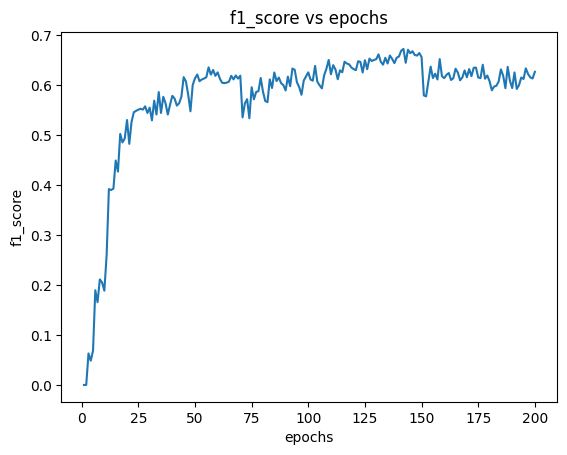

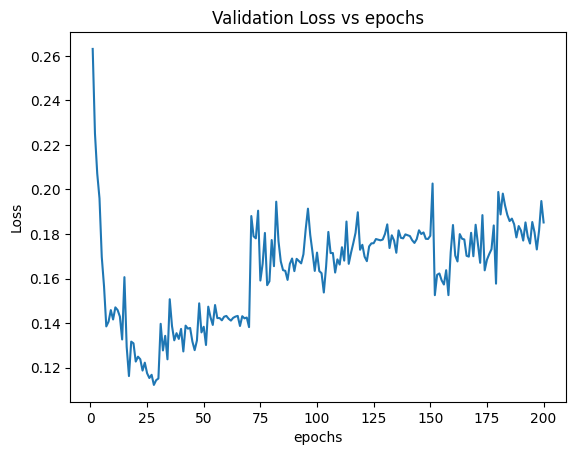

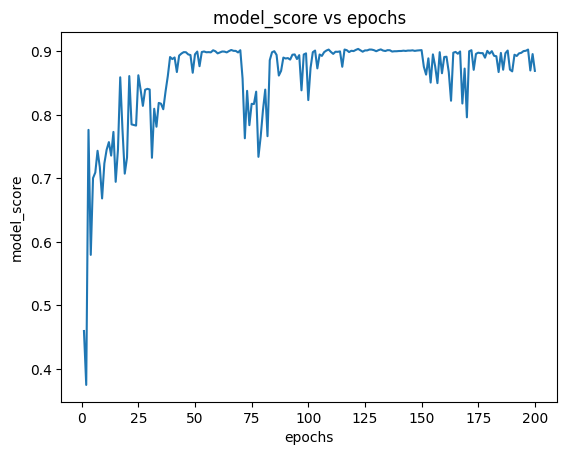

In [6]:
k = len(f1_arr)
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,k+1), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,k+1), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Validation Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,k+1), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

print(max_ms) 

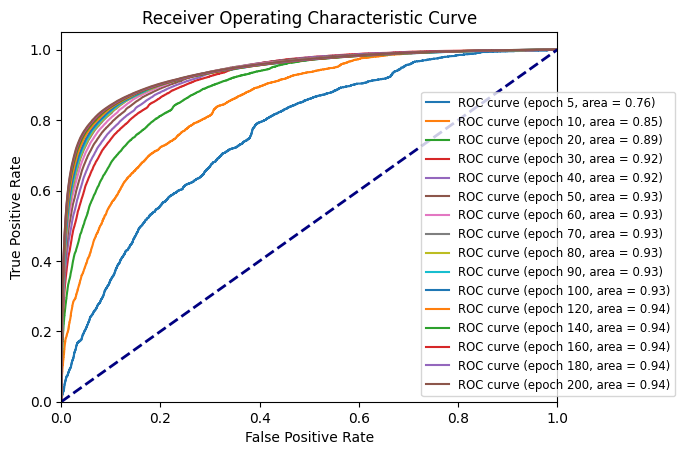

In [7]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)

In [8]:
# model.eval()
# val_preds, val_labels = [], []
# heatmap_images = []  # Store heatmap images for positive samples with AUC score < 1
# with torch.no_grad():
#     for images, labels in tqdm(val_dataloader):
#         images, labels = images.to(device), labels.to(device)
            
#         # Forward pass
#         outputs = model(images)
#         outputs = torch.sigmoid(outputs)
        
#         # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
#         val_preds += outputs.tolist()
#         val_labels += labels.tolist()

#         # Generate heatmaps for positive samples with AUC score < 1
#         for idx, label in enumerate(labels):
#             if roc_auc_score([label.item()], [outputs[idx].item()]) < 1:
#                 # Convert the image to numpy array and normalize
#                 image = images[idx].cpu().numpy().transpose(1, 2, 0)
#                 image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

#                 # Resize the image to match the input size of the model
#                 image = cv2.resize(image, (image_size, image_size))

#                 # Generate the heatmap
#                 heatmap = cam_generate(model, image, label.item())

#                 # Normalize the heatmap
#                 heatmap = cv2.normalize(heatmap, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

#                 # Store the heatmap image
#                 heatmap_images.append(heatmap)

# val_labels = np.array(val_labels)
# val_preds = np.array(val_preds)
# threshold = 0.5  # set your threshold value here
# thresholded_val_preds = np.where(val_preds > threshold, 1, 0)

# # Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
# metrics_dict = {}
# for label in range(num_classes):
#     precision, recall, _ = precision_recall_curve(val_labels[:, label], thresholded_val_preds[:, label])
#     auc = roc_auc_score(val_labels[:, label], val_preds[:, label])
#     f1 = f1_score(val_labels[:, label], thresholded_val_preds[:, label], average='binary', zero_division=1)
#     metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}

# # Print the dictionary in tabular format using the tabulate library
# headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
# table = []
# for label in range(num_classes):
#     row = [label]
#     for metric in ['Precision', 'Recall', 'F1', 'AUC']:
#         values = metrics_dict[label][metric]
#         if values.size > 0:
#             value_str = '{:.4f}'.format(values.mean(), values.max())
#         else:
#             value_str = '0.00'
#         row.append(value_str)
#     table.append(row)

# print(tabulate(table, headers=headers))

# # Visualize the heatmap images
# for idx, heatmap_image in enumerate(heatmap_images):
#     cv2.imshow(f"Heatmap {idx}", heatmap_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [9]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tabulate import tabulate

model.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(val_dataloader):
        images, labels = images.to(device), labels.to(device)
            
        # Forward pass
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        
        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        val_preds += outputs.tolist()
        val_labels += labels.tolist()

val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
threshold = 0.5  # set your threshold value here
thresholded_val_preds = np.where(val_preds > threshold, 1, 0)

# Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
metrics_dict = {}
for label in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels[label], thresholded_val_preds[label])
    auc = roc_auc_score(val_labels[label], val_preds[label])
    f1 = f1_score(val_labels[label], thresholded_val_preds[label], average='binary', zero_division=1)
    metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}
    
# Print the dictionary in tabular format using the tabulate library
headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
table = []
for label in range(num_classes):
    row = [label]
    for metric in ['Precision', 'Recall', 'F1', 'AUC']:
        values = metrics_dict[label][metric]
        if values.size > 0:
            value_str = '{:.4f}'.format(values.mean(), values.max())
        else:
            value_str = '0.00'
        row.append(value_str)
    table.append(row)

print(tabulate(table, headers=headers))

100%|██████████| 28/28 [00:06<00:00,  4.02it/s]

  Label    Precision    Recall      F1     AUC
-------  -----------  --------  ------  ------
      0       0.35      0.3333  0       0.8947
      1       0.35      0.3333  0       0.9474
      2       0.6833    0.6667  1       1
      3       0.525     0.5     0       0.9474
      4       0.6833    0.6667  1       1
      5       0.6833    0.6667  1       1
      6       0.6833    0.6667  1       1
      7       0.6833    0.6667  1       1
      8       0.6833    0.6667  1       1
      9       0.6833    0.6667  1       1
     10       0.6833    0.6667  1       1
     11       0.6833    0.6667  1       1
     12       0.35      0.3333  0       0.9474
     13       0.5167    0.6667  0.6667  1
     14       0.35      0.3333  0       0.8947
     15       0.35      0.3333  0       0.7895
     16       0.35      0.3333  0       0.5789
     17       0.525     0.5     0       0.8947
     18       0.6833    0.6667  1       1
     19       0.7       0.6667  1       1
